# Session 3 - Practical: Coding finite basis PINNs and extreme learning machine FBPINNs in JAX

## Goal

The goal of this practical is to:
- Understand how to use **domain decomposition** to improve the **efficiency and accuracy** of physics-informed neural networks (PINNs)
- Understand how it is possible to further accelerate training by **linearising** the model and using a **least-squares** solver to train it.

## Contents

This practical has two parts:
- Part 1: Training a finite basis PINN (**FBPINN**) to solve the 1D harmonic oscillator
- Part 2: Using **extreme learning learning machines** and **numerical linear algebra** to further accelerate training.

Please see the lecture slides from Session 3 for more explanation on these topics.

## Part 1: Training a finite basis PINN (**FBPINN**) to solve the 1D harmonic oscillator

<div style="text-align: center; margin-top: 20px">
    <img src="https://raw.githubusercontent.com/benmoseley/FBPINNs/main/images/workflow.png" width=800px>
</div>
<div style="text-align: center; font-weight: bold; margin-top: 5px; margin-bottom: 20px">
    Fig 1: FBPINN workflow overview
</div>

### How are FBPINNs different from PINNs?

As discussed in the lecture, to improve the scalability of PINNs to high frequency/ multiscale solutions:

- FBPINNs divide the problem domain into many small, **overlapping subdomains** (Fig 1).

- A neural network is placed within each subdomain, and the solution to the PDE is defined as the **summation over all subdomain networks**.

- Each subdomain network is **locally confined** to its subdomain by multiplying it by a smooth, differentiable window function.

- Finally, the inputs of each network are **individually normalised** over their subdomain.

The hypothesis is that this "divide and conquer" approach significantly reduces the complexity of the PINN optimisation problem. Furthermore, individual subdomain normalisation ensures the "effective" frequency each subdomain network sees is low, reducing the effect of spectral bias.

<div style="text-align: center; margin-top: 20px">
    <img src="images/fbpinn.png" alt="FBPINN workflow overview" width=500px>
</div>
<div style="text-align: center; font-weight: bold; margin-top: 5px; margin-bottom: 20px">
    Fig 2: Example FBPINN individual subdomain solutions, window functions, and subdomains, for the 1D harmonic oscillator problem
</div>

Note that FBPINNs can simply be thought of as defining a **custom neural network architecture** for PINNs. We train PINNs using **exactly the same loss function** as before.

For the 1D harmonic oscillator problem, we write the equation for the FBPINN architecture as:
$$
\hat{u}(t,\mathbf{\theta})=  \sum_{j = 1}^J \omega_j(t) NN_j((t-\mu_j)/\sigma_j, \mathbf{\theta}_j)~,
$$
where $NN_j$ are the individual subdomain networks with learnable parameters $\mathbf{\theta}_j$, $\omega_j$ are window functions constraining each subdomain network to its subdomain, $\mu_j$ and $\sigma_j$ are the center and half-width of each subdomain, and $J$ is the total number of subdomains.

To ensure stability during training, we also impose that the window functions form a **partition of unity**. This is a fancy way of saying that they should always sum to 1, i.e. $\sum_{j = 1}^J  \omega_j(t)=1 \ \ \forall t$. An easy way of doing this in practice is picking some unnormalised window function, $\hat{\omega}_j$, (say for example $\hat{\omega}_j= Gaussian(\mu_j, \sigma_j)$), and then defining
$$
\omega_j(t) := \frac{\hat{\omega}_j(t)}{\sum_{i = 1}^J  \hat{\omega}_i(t)}~.
$$

In [1]:
import time
from functools import partial

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import jax
import jax.numpy as jnp
import optax

def exact_solution(d, w0, t):
    "Computes the analytical solution to the under-damped harmonic oscillator."
    assert d < w0
    w = jnp.sqrt(w0**2-d**2)
    phi = jnp.arctan(-d/w)
    A = 1/(2*jnp.cos(phi))
    cos = jnp.cos(phi+w*t)
    exp = jnp.exp(-d*t)
    u = exp*2*A*cos
    return u

def plot_result(i, t_physics_batch, t_boundary, t_test_batch, u_exact_batch, u_test_batch):
    "Plots the PINN's prediction"
    test_error = jnp.mean(jnp.abs(u_test_batch-u_exact_batch)/u_exact_batch.std())
    plt.figure(figsize=(8,3))
    plt.scatter(t_physics_batch[:,0], jnp.zeros_like(t_physics_batch)[:,0], s=20, lw=0, color="tab:blue", alpha=0.6, label="Collocation points")
    plt.scatter(t_boundary, 0, s=20, lw=0, color="tab:red", alpha=0.6, label="Boundary point")
    plt.plot(t_test_batch[:,0], u_exact_batch[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
    plt.plot(t_test_batch[:,0], u_test_batch[:,0], label="PINN solution", color="tab:green")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Training step {i+1}    Relative L1 test error: {test_error:.2%}")
    plt.legend()
    plt.show()

class FCN:
    """Fully connected network in JAX, using only jax.numpy

    Note for the curious reader: any functions which are designed for JAX transformations (vmap, grad, jit, etc)
    should not include side-effects (a side-effect is any effect of a function that doesn’t appear in its output).

    But standard python class methods (e.g. def __init__(self, ..)) often adjust `self` outside of the method.
    This is risky, unless you know exactly what you are doing; and is why we only define static methods here.

    This means the FCN class is really just a collection of functions, i.e. a convienent namespace,
    and we carry around the state of the network (i.e. its `parameters`, normally contained in `self` in PyTorch)
    explicitly in our JAX code, passing it explicitly to each method. See here for more discussion:
    https://docs.jax.dev/en/latest/stateful-computations.html
    """

    @staticmethod
    def init_parameters(key, layer_sizes):
        """Initialise the parameters of the network.
        Parameters:
            key: current JAX RNG state
            layer_sizes: list defining the number of layers and the number of channels per layer, including
            input/output layers, e.g. [1,16,16,1]
        Returns:
            parameters: list of randomly initialised weights and biases [(W0, b0), ...]

        Note: JAX uses explicit random seed management; so we need to pass the current RNG state (`key`) explicitly
        to any `jax.random` calls, and split the RNG state by hand.
        """

        keys = jax.random.split(key, len(layer_sizes)-1)# split the key
        parameters = [FCN._random_layer_parameters(k, m, n)
                      for k, m, n in zip(keys, layer_sizes[:-1], layer_sizes[1:])]# initialise all layers

        return parameters

    @staticmethod
    def _random_layer_parameters(key, m, n):
        "Randomly intialise the parameters of a single layer"

        W_key, b_key = jax.random.split(key)
        v = jnp.sqrt(1/m)# LeCun initialisation
        W = jax.random.uniform(W_key, (n, m), minval=-v, maxval=v)
        b = jax.random.uniform(b_key, (n,), minval=-v, maxval=v)

        return W,b

    @staticmethod
    def forward(parameters, x):
        """Forward pass of the network.
        Parameters:
            parameters: list of weights and biases [(W0,b0), ...]
            x: SINGLE input point of shape (xdim=layer_sizes[0],)
        Returns:
            u: SINGLE output point of shape (udim=layer_sizes[-1],)

        Note: a key philosophical difference between JAX and PyTorch is that in JAX we define non-batched
        operations (like the forward pass of the network with a SINGLE input point), and then use `vmap`
        afterwards to define the batched version (e.g. for evaluating the network over many points).
        With experience, this is a powerful way to build sophisticated, peformant, flexible code which remains
        readable and is less bug-prone.
        """

        assert x.ndim == 1
        activation_fn = jnp.tanh

        for W, b in parameters[:-1]:# W has shape (m, n), b has shape (n,)
            x = jnp.dot(W, x) + b
            x = activation_fn(x)
        W, b = parameters[-1]
        u = jnp.dot(W, x) + b

        assert u.ndim == 1
        return u

### Step 1: Defining the FBPINN model JAX

The first step is to define this FBPINN architecture in JAX. To do this, we define the `FBPINN` class, which initialises all of the subdomain network parameters, defines the subdomain ranges and window functions, and computes the individual outputs of each subdomain. The `FBPINN.forward` method then computes the final output of the FBPINN: the summation over all subdomains network outputs.

> Task 1: complete the `FBPINN.init_parameters`, `FBPINN.forward_single_subdomain`, and `FBPINN.forward` functions.

In [2]:
class FBPINN:
    "Finite basis physics-informed neural network"

    @staticmethod
    def init_parameters(key, layer_sizes, J):
        """Initialise the parameters for all subdomain networks inside the FBPINN.
        Parameters:
            key: current JAX RNG state
            layer_sizes: list defining the number of layers and the number of channels per layer, including
            input/output layers, e.g. [1,16,16,1], which each subdomain network uses
            J: total number of subdomains
        Returns:
            parameters: list of randomly initialised weights and biases [(W0, b0), ...] with a leading subdomain dimension.
            i.e. W0 now has shape (J, m, n), and b has shape (J, n)
        """

        ## Task: initialise the parameters for all of the subdomain networks. Each subdomain network
        ## should use the same FCN architecture with the same `layer_sizes`.
        ## Hint: re-use FCN.init_params, and `vmap` it to generate all parameters at once.

        keys = jax.random.split(key, J)
        parameters = jax.vmap(FCN.init_parameters, in_axes=(0,None))(keys, layer_sizes)

        ##

        for W,b in parameters: assert W.ndim == 3 and b.ndim == 2 and W.shape[0] == b.shape[0] == J
        return parameters

    @staticmethod
    def get_subdomain_tranges(J, width):
        """Gets the tmin, tmax range of each subdomain, assuming a [0,1] problem domain, and a regular domain decomposition.
        Parameters:
            J: total number of subdomains
            width: width of each subdomain
        Returns:
            tranges: array of shape (J, 2) containing tmin, tmax of each subdomain
        """

        assert width > 1/(J-1), f"width is too small: {J} subdomains of width {width} will not fill entire [0,1] interval"

        if J == 1:
            t_centers = jnp.array([0.5])
        else:
            t_centers = jnp.linspace(0,1,J)
        tmins = t_centers - width/2
        tmaxs = t_centers + width/2
        tranges = jnp.stack([tmins, tmaxs], axis=1)# (J, 2)

        assert tranges.shape == (J, 2)
        return tranges

    @staticmethod
    def window(trange, t):
        """Defines the window function used by the FBPINN, in this case a cosine window function,
        for a SINGLE input point of shape (1,)
        """

        assert t.shape == (1,) and trange.shape == (2,)
        tmin, tmax = trange
        mu, sd = (tmin+tmax)/2, (tmax-tmin)/2
        w = ((1+jnp.cos(jnp.pi*(t-mu)/sd))/2)**2
        w = jnp.heaviside(t-tmin,1)*jnp.heaviside(tmax-t,1)*w

        return w

    @staticmethod
    def forward_single_subdomain(parameters_for_a_single_subdomain, trange, t):
        """Computes the output of a single subdomain in the FBPINN.
        Parameters:
            parameters_for_a_single_subdomain: list of FCN weights and biases [(W0,b0), ...]
            for a single subdomain (no leading subdomain dimension)
            trange: array of shape (2,) containing the tmin,tmax of the subdomain
            t: a SINGLE input point of shape (1,)
        Returns:
            u: a SINGLE solution point at t, of shape (1,)
            w: the value of the subdomain's window function at t, of shape (1,)

        This function should compute u_j(t) = window_j(t) * NN_j(norm_j(t)) in the FBPINN ansatz.
        """

        assert t.shape == (1,) and trange.shape == (2,)
        tmin, tmax = trange
        mu, sd = (tmin+tmax)/2, (tmax-tmin)/2

        ## Task: finish evaluating the forward function for a single subdomain network in the FBPINN
        ## Don't forget to normalise the input of the network within the subdomain range
        ## and apply the window function to the output of the network

        w = FBPINN.window(trange, t)
        t = (t-mu)/sd
        u = FCN.forward(parameters_for_a_single_subdomain, t)
        u = w*u

        ##

        # `u` should be the subdomain output, u_j(t), (with the window applied), `w` should be the window value, window_j(t)
        assert u.shape == w.shape == (1,)
        return u, w

    @staticmethod
    def forward(parameters, tranges, t):
        """Computes the FBPINN solution.
        Parameters:
            parameters: list of FCN weights and biases [(W0,b0), ...] with leading subdomain dimension
            tranges: array of shape (J, 2) containing tmin, tmax of each subdomain
            t: a SINGLE input point of shape (1,)
        Returns:
            u: a SINGLE solution point of shape (1,)

        This function should compute the full FBPINN solution, u(t) = sum_j (1/window_norm(t)) u_j(t), where
        window_norm(t) = 1 / (sum_j window_j(t)) is used to ensure a partition of unity (i.e. all window functions sum to 1).
        """

        assert t.shape == (1,) and tranges.ndim == 2 and tranges.shape[1] == 2

        ## Task: finish defining the forward function.
        ## Hint: `vmap` forward_single_subdomain, and sum the subdomain solutions together
        ## don't forget to apply the partition of unity (window normalisation) after summing the subdomain solutions

        us, ws = jax.vmap(FBPINN.forward_single_subdomain, in_axes=(0,0,None))(
            parameters, tranges, t)# (J, 1)

        u = us.sum(axis=0)/ws.sum()# dividing by ws.sum() ensures a partition of unity

        ##

        assert u.shape == (1,)
        return u

> Task 2: plot the domain decomposition, window functions, and the individual FBPINN subdomain solutions for the untrained FBPINN.

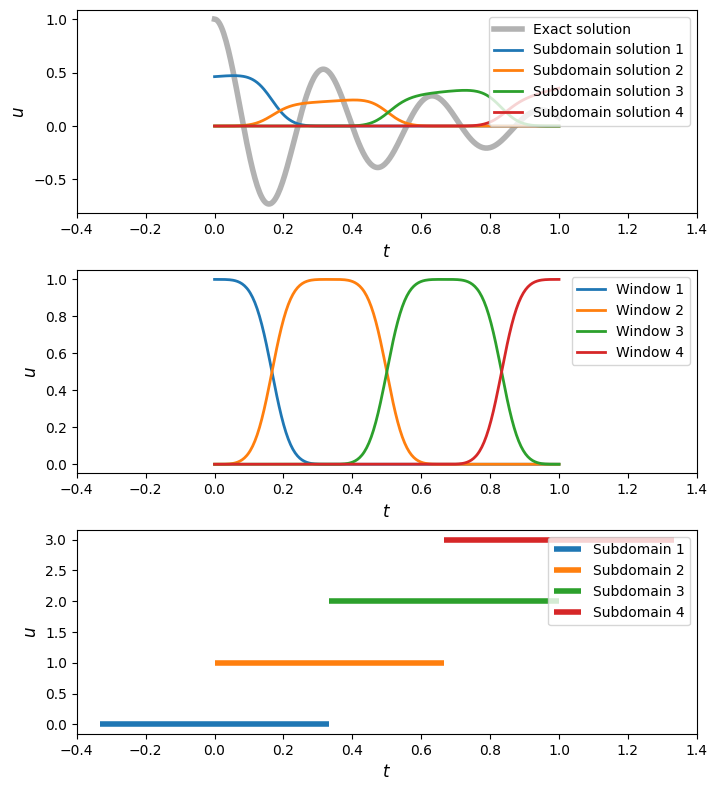

In [3]:
# set random seed
key = jax.random.PRNGKey(0)

# define the neural network architecture and initialise its parameters
network = FBPINN
J = 4
parameters = network.init_parameters(key, [1,8,1], J)
tranges = network.get_subdomain_tranges(J, 2/(J-1))

# define ODE parameters
d, w0 = 2, 20
mu, k = 2*d, w0**2

# get dense test points and exact solution to compare to
t_test_batch = jnp.linspace(0,1,300).reshape(-1,1)
u_exact_batch = jax.vmap(exact_solution, in_axes=(None,None,0))(d, w0, t_test_batch)


## Task: plot the domain decomposition, window functions, and the individual FBPINN subdomain solutions of the untrained FBPINN
## hint: you can `vmap` `FBPINN.forward_single_subdomain` to get all individual solutions and their window functions,
## and the domain decomposition is defined by `tranges`. Don't forget to apply the partition of unity to the individual
# subdomain solutions and window functions after you `vmap` `FBPINN.forward_single_subdomain`

us, ws = jax.vmap(jax.vmap(FBPINN.forward_single_subdomain, in_axes=(None,None,0)), in_axes=(0,0,None))(
    parameters, tranges, t_test_batch)# (J, N)
us = us/ws.sum(0, keepdims=True)# apply partition of unity
ws = ws/ws.sum(0, keepdims=True)# apply partition of unity

plt.figure(figsize=(8,3*3+0.4))
plt.subplot(3,1,1)
plt.plot(t_test_batch, u_exact_batch, label="Exact solution", color="tab:grey", lw=4, alpha=0.6)
for j in range(J):
    plt.plot(t_test_batch, us[j], label=f"Subdomain solution {j+1}", lw=2)
plt.legend(loc="upper right")
plt.xlim(-0.4,1.4)
plt.xlabel("$t$", fontsize="large")
plt.ylabel("$u$", fontsize="large")
plt.subplot(3,1,2)
for j in range(J):
    plt.plot(t_test_batch, ws[j], label=f"Window {j+1}", lw=2)
plt.legend(loc="upper right")
plt.xlim(-0.4,1.4)
plt.xlabel("$t$", fontsize="large")
plt.ylabel("$u$", fontsize="large")
plt.subplot(3,1,3)
for j in range(J):
    plt.hlines(j%J, tranges[j][0], tranges[j][1], linewidth=4, label=f"Subdomain {j+1}", color=colors[j%len(colors)])
plt.legend(loc="upper right")
plt.xlim(-0.4,1.4)
plt.xlabel("$t$", fontsize="large")
plt.ylabel("$u$", fontsize="large")
plt.subplots_adjust(hspace=0.28)
plt.show()

##

### Step 2: Computing the PINN loss function

As mentioned above, FBPINNs are trained using **exactly the same loss function** as PINNs. So we can simply reuse all of the loss functions we wrote for the previous PINN practical.

> Task 3: simply run the cell below to redefine the PINN loss functions.

In [4]:
def FBPINN_physics_loss(parameters, tranges, t, network, mu, k):
    "Compute the physics loss for the 1D harmonic oscillator problem"

    assert t.shape == (1,)

    def u_fn(t):
        """Calls network.forward, isolating u as a scalar function of a scalar input
        suitable for jax.grad"""
        return network.forward(parameters, tranges, t.reshape(1,)).squeeze()# has shape ()
    t = t.squeeze()# has shape ()

    u = u_fn(t)# has shape ()
    dudt_fn = jax.grad(u_fn)
    dudt = dudt_fn(t)

    d2udt2_fn = jax.grad(dudt_fn)
    d2udt2 = d2udt2_fn(t)

    loss_physics = (d2udt2 + mu*dudt + k*u)**2

    assert loss_physics.shape == ()
    return loss_physics


def FBPINN_boundary_losses(parameters, tranges, t, network):
    "Compute the two boundary losses for the 1D harmonic oscillator problem"

    assert t.shape == (1,)

    def u_fn(t):
        """Calls network.forward, isolating u as a scalar function of a scalar input
        suitable for jax.grad"""
        return network.forward(parameters, tranges, t.reshape(1,)).squeeze()# has shape ()
    t = t.squeeze()# has shape ()

    u = u_fn(t)
    dudt_fn = jax.grad(u_fn)
    dudt = dudt_fn(t)
    loss_displacement, loss_velocity = (u-1)**2, (dudt-0)**2

    assert loss_displacement.shape == loss_velocity.shape == ()
    return loss_displacement, loss_velocity


def FBPINN_loss_batch(parameters, tranges, t_boundary, t_physics_batch, network, mu, k):
    "Computes the total FBPINN loss for the harmonic oscillator problem, across a batch of collocation points"

    assert t_boundary.shape == (1,) and t_physics_batch.ndim == 2

    loss_physics = jnp.mean(jax.vmap(FBPINN_physics_loss, in_axes=(None, None, 0, None, None, None))(
        parameters, tranges, t_physics_batch, network, mu, k))

    loss_displacement, loss_velocity = FBPINN_boundary_losses(parameters, tranges, t_boundary, network)

    assert loss_physics.shape == loss_displacement.shape == loss_velocity.shape == ()

    # sum all the losses together, weighting terms appropriately
    loss = 1e-4*loss_physics + loss_displacement + 1e-1*loss_velocity

    return loss

### Step 3: Training the FBPINN and evaluating performance

The final step is to train the FBPINN. We will use the same problem setup and training code as the PINN practical.

> Task 4: train the FBPINN using the training code provided.

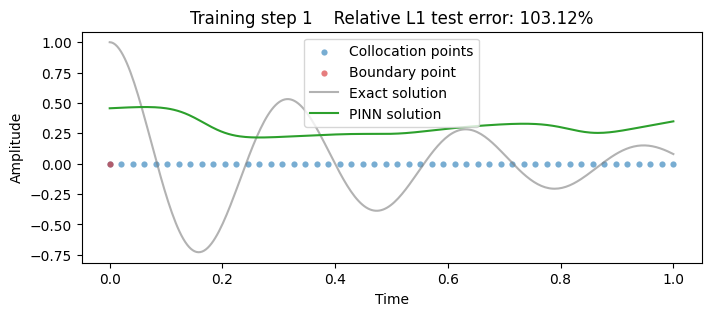

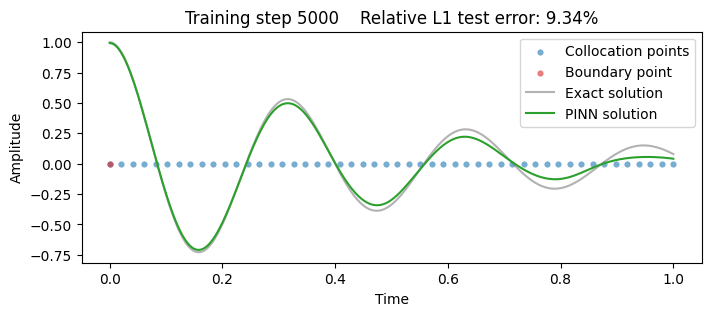

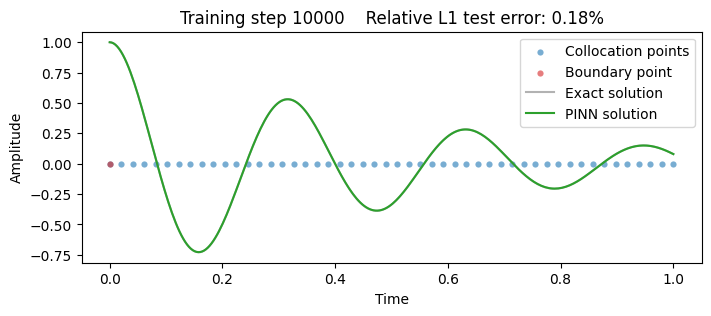

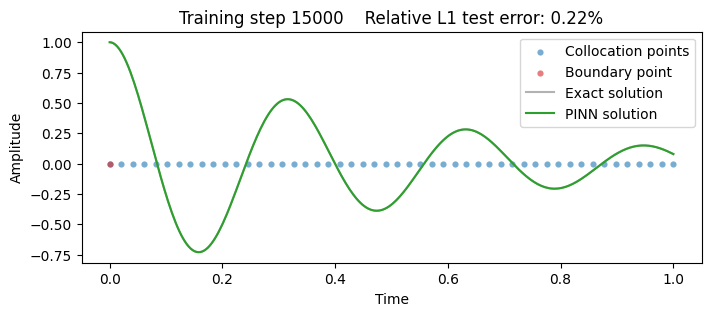

Total training time: 13.948628187179565 seconds


In [5]:
@partial(jax.jit, static_argnums=(1,6))# JAX best practice is to only `jit` your highest-level function
def FBPINN_step(opt_state, optimiser, parameters, tranges, t_boundary, t_physics_batch, network, mu, k):
    "Updates FBPINN parameters using the `optax` Adam optimiser"

    # get loss and gradient over batch
    loss, grads = jax.value_and_grad(FBPINN_loss_batch, argnums=0)(
        parameters, tranges, t_boundary, t_physics_batch, network, mu, k)

    # apply parameter update
    updates, opt_state = optimiser.update(grads, opt_state, parameters)
    parameters = optax.apply_updates(parameters, updates)

    return loss, opt_state, parameters



# Train the FBPINN

# define boundary point, for the boundary loss
t_boundary = jnp.array([0.])# has shape (1,)

# define batch of training points over the entire problem domain [0,1], for the physics loss
t_physics_batch = jnp.linspace(0,1,50).reshape(-1,1)# has shape (50, 1)

# define the optimiser
optimiser = optax.adam(learning_rate=1e-3)
opt_state = optimiser.init(parameters)

# start training
start = time.time()
for i in range(15000):

    # update parameters
    loss, opt_state, parameters = FBPINN_step(
        opt_state, optimiser, parameters, tranges, t_boundary, t_physics_batch, network, mu, k)

    # plot the result as training progresses
    if (i+1)%5000 == 0 or i==0:

        # get PINN prediction and plot
        u_test_batch = jax.vmap(network.forward, in_axes=(None,None,0))(parameters, tranges, t_test_batch)
        plot_result(i, t_physics_batch, t_boundary, t_test_batch, u_exact_batch, u_test_batch)

print(f"Total training time: {time.time()-start} seconds")

> Task 5: measure the total training time, and compare this to the JAX PINN. Which is faster, and why?

> Task 6: increase the solution frequency, e.g. by setting `w0 = 40`, can you beat the PINN's performance with the FBPINN?

> Optional extension tasks. If you have the time, consider these extensions:
> 1. Can you optimise training speed and convergence rate any further (e.g. by increasing the number of subdomains, size of the subdomain networks, or amount of overlap between the subdomains)?
> 2. Plot test accuracy vs solution frequency: can the FBPINN scale to very high frequencies?

In [6]:
## Task: measure the total training time, and compare this to the JAX PINN. Which is faster, and why?

## Task: increase the solution frequency, e.g. by setting `w0 = 40`, can you beat the PINN's performance with the FBPINN?

## Task (optional extensions): if you have the time, consider these extensions:
    # 1. Can you optimise training speed and convergence rate any further (e.g. by increasing the
    # number of subdomains, size of the subdomain networks, or amount of overlap between the subdomains)?
    # 2. Plot test accuracy vs solution frequency: can the FBPINN scale to very high frequencies?

## Part 2: Using **extreme learning learning machines** and **numerical linear algebra** to further accelerate training

### How can we further accelerate FBPINNs by linearising the model?

As discussed in the lecture, the major downside to FBPINNs is that their loss function is still **highly nonlinear**, which means they require a nonlinear optimisation algorithm to train them (and in practice, most often, we use gradient descent).

These types of optimisation algorithms often add a significant **computational overhead** - for example, when using gradient descent, computing derivatives of the FBPINN solution and loss function at each gradient descent step is very expensive (even with the power of JAX!).

To overcome this limitation, we are going to **linearise** the FBPINN model with respect to its trainable parameters. For **linear ODEs and PDEs**, this will allow us to turn their loss function into a **least-squares** problem which can be solved much more efficiently using **traditional numerical linear algebra techniques**, rather than gradient desent.

### Extreme learning machine FBPINNs (aka ELM-FBPINNs)

To linearise FBPINNs, we will use **[extreme learning machines](https://www.sciencedirect.com/science/article/pii/S0925231206000385)** as the subdomain networks in the FBPINN. An extreme learning machine is simply a **randomly initialised network, where all of its hidden parameters are fixed and not trained**, and only the **weights of the last layer** are trained.

More specifically, we now assume the FBPINN solution can be written down as
$$
\hat{u}(t,\mathbf{a})=  \sum_{j = 1}^J \omega_j(t) \sum_{k = 1}^K a_{jk} \phi_{jk}((t-\mu_j)/\sigma_j, \mathbf{\theta}_{jk})~,
$$
where $\phi_{jk}(\cdot,\mathbf{\theta}_{jk})$ are the $K$ outputs (features) of the last hidden layer of each subdomain network, where the hidden parameters of each subdomain network $\mathbf{\theta}_{jk}$ are randomly initialised and not trained. Only the weights of the last layer of each subdomain network, $a_{jk}$, are treated as trainable parameters.


Note that we can shift all summations to the left:
$$
\hat{u}(t,\mathbf{a})=  \sum_{j = 1}^J \sum_{k = 1}^K a_{jk} \ \omega_j(t) \phi_{jk}((t-\mu_j)/\sigma_j, \mathbf{\theta}_{jk})~,
$$
And it is now clear that this model is **linear** in the trainable coefficients $a_{jk}$.

<div style="text-align: center; margin-top: 20px">
    <img src="images/elm_fbpinn_basis.png" alt="FBPINN workflow overview" width=500px>
</div>
<div style="text-align: center; font-weight: bold; margin-top: 5px; margin-bottom: 20px">
    Fig 3: Example randomly initialised basis functions in the ELM-FBPINN (with windows applied). In this example J=4 and K=16.
</div>

### Training ELM-FBPINNs

Again, we train ELM-FBPINNs using the same loss function as PINNs and FBPINNs. Recall, for the 1D harmonic oscillator problem, this is given by
$$
L(\theta)= (\hat{u}(0,\theta) - 1)^2 + \lambda_1 \left(\frac{d \hat{u}}{dt}(0,\theta) - 0\right)^2 + \frac{\lambda_2}{N_I} \sum^{N_I}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] \hat{u}(t_{i},\theta)  \right)^2~.
$$
Substituting in our equation for the ELM-FBPINN solution, and only treating the coefficients $a_{jk}$ as learnable, we get
$$
\begin{aligned}
L(\mathbf{a}) &= \left(\sum_{j = 1}^J \sum_{k = 1}^K a_{jk} \omega_j(t) \phi_{jk}((0-\mu_j)/\sigma_j, \mathbf{\theta}_{jk}) - 1\right)^2 \\
& + \lambda_1 \left(\frac{d }{dt}\left[\sum_{j = 1}^J \sum_{k = 1}^K a_{jk} \omega_j(t) \phi_{jk}((0-\mu_j)/\sigma_j, \mathbf{\theta}_{jk})\right] - 0\right)^2 \\
&+ \frac{\lambda_2}{N_I} \sum^{N_I}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] \sum_{j = 1}^J \sum_{k = 1}^K a_{jk} \omega_j(t) \phi_{jk}((t_i-\mu_j)/\sigma_j, \mathbf{\theta}_{jk})  \right)^2~.
\end{aligned}
$$
We can see that, **because our ODE and boundary conditions are linear operators, we can shift all summations to the left**:
$$
\begin{aligned}
L(\mathbf{a}) &= \left(\sum_{j = 1}^J \sum_{k = 1}^K a_{jk} \ \omega_j(t) \phi_{jk}((0-\mu_j)/\sigma_j, \mathbf{\theta}_{jk}) - 1\right)^2 \\
& + \lambda_1 \left(\sum_{j = 1}^J \sum_{k = 1}^K a_{jk} \ \frac{d }{dt}\left[\omega_j(t) \phi_{jk}((0-\mu_j)/\sigma_j, \mathbf{\theta}_{jk})\right] - 0\right)^2 \\
&+ \frac{\lambda_2}{N_I} \sum^{N_I}_{i} \left(  \sum_{j = 1}^J \sum_{k = 1}^K a_{jk} \ \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] \omega_j(t) \phi_{jk}((t_i-\mu_j)/\sigma_j, \mathbf{\theta}_{jk}) - 0 \right)^2~.
\end{aligned}
$$
This allows us to re-write minimising the loss as the following **least-squares problem**:
$$
\min_{\mathbf{a}}  \left\| \mathbf{B}_1 \mathbf{a} - \mathbf{g}_1 \right\|^2  + \lambda_1 \left\| \mathbf{B}_2 \mathbf{a} - \mathbf{g}_2 \right\|^2 + \frac{\lambda_2}{N_I} \left\| \mathbf{N} \mathbf{a} - \mathbf{f} \right\|^2~,
$$
Where the matrices $\mathbf{B}_1 \in \mathbb{R}^{1 \times JK}$, $\mathbf{B}_2 \in \mathbb{R}^{1 \times JK}$, and $\mathbf{N} \in \mathbb{R}^{N_I \times JK}$ contain evaluations of the boundary/ODE operators on the windowed basis functions at boundary/collocation points, and the vectors $\mathbf{g}_1 = \mathbf{1} \in \mathbb{R}^{1}$, $\mathbf{g}_2 = \mathbf{0} \in \mathbb{R}^{1}$, and $\mathbf{f} = \mathbf{0} \in \mathbb{R}^{N_I}$ contain evaluations of the boundary/ODE forcing functions at boundary/collocation points.

Note, the least-squares problem can be equivalently written as a single combined least-squares problem
$$
\min_{\mathbf{a}} \left\| \mathbf{M} \mathbf{a} - \mathbf{h} \right\|^2~,
$$
by vertically stacking the matrices and vectors,
$$
\mathbf{M} := \begin{bmatrix} \sqrt{\frac{\lambda_2}{N_I}} \mathbf{N} \\ \mathbf{B}_1 \\ \sqrt{\lambda_1} \mathbf{B}_2 \end{bmatrix}, \quad \mathbf{h} := \begin{bmatrix} \sqrt{\frac{\lambda_2}{N_I}} \mathbf{f} \\ \mathbf{g}_1 \\ \sqrt{\lambda_1} \mathbf{g}_2 \end{bmatrix}~.
$$

We are done! All we need to do now is assemble the least-squares system, and then use a traditional **least-squares solver** (such as `jax.numpy.linalg.lstsq`) to find $a_{jk}$, avoiding the need for gradient descent!

### Step 1: Defining the ELM-FBPINN model in JAX

Our first step is to rewrite the `FBPINN` class so that it uses ELMs as its subdomain networks. We also need to be able to compute and access the outputs of the $J\times K$ windowed basis functions, $\omega_j \phi_{jk}$.

> Task 1: complete the `ELMFBPINN.forward` function

In [7]:
class ELMFBPINN(FBPINN):
    "Extreme learning machine FBPINN"

    @staticmethod
    def forward_basis_single_subdomain(parameters_for_a_single_subdomain, trange, t):
        """Computes the (unnormalised) windowed basis functions of a single subdomain in the ELM-FBPINN.
        Parameters:
            parameters_for_a_single_subdomain: list of FCN weights and biases [(W0,b0), ...]
            for a single subdomain (no leading subdomain dimension)
            trange: array of shape (2,) containing the tmin,tmax of the subdomain
            t: a SINGLE input point of shape (1,)
        Returns:
            phi: array of windowed basis function values at t, of shape (K,)
            w: the value of the subdomain's window function at t, of shape (1,)

        This function computes window_j(t) * phi_jk (norm_j(t)) for all k
        i.e. the unnormalised windowed basis functions for a single subdomain
        """

        assert t.shape == (1,) and trange.shape == (2,)
        tmin, tmax = trange
        mu, sd = (tmin+tmax)/2, (tmax-tmin)/2

        w = FBPINN.window(trange, t)
        t = (t-mu)/sd
        phi = FCN.forward(parameters_for_a_single_subdomain, t)
        phi = jnp.tanh(phi)# apply a tanh activation to output of FCN
        phi = w*phi# phi has shape (K,) and w has shape (1,)

        assert w.shape == (1,) and phi.ndim == 1
        return phi, w

    @staticmethod
    def forward_basis(parameters_fixed, tranges, t):
        """Computes the windowed basis functions for all subdomains in the ELM-FBPINN.
        Parameters:
            parameters_fixed: list of FCN weights and biases [(W0,b0), ...] with leading subdomain dimension
            tranges: array of shape (J, 2) containing tmin, tmax of each subdomain
            t: a SINGLE input point of shape (1,)
        Returns:
            phi: array of windowed basis function values at t, of shape (J,K), with POU applied

        This function computes (1/window_norm(t)) * window_j(t) * phi_jk (norm_j(t)) for all j and k
        i.e. the normalised windowed basis functions for all subdomains
        """

        assert t.shape == (1,)
        phis, ws = jax.vmap(ELMFBPINN.forward_basis_single_subdomain, in_axes=(0, 0, None))(
            parameters_fixed, tranges, t)# phis has shape (J,K), ws have shape (J,1)
        phis = phis/ws.sum()# apply POU, has shape (J,K)
        assert phis.ndim == 2
        return phis


    @staticmethod
    def forward(parameters_fixed, tranges, a, t):
        """Computes the ELM-FBPINN solution.
        Parameters:
            parameters_fixed: list of FCN weights and biases [(W0,b0), ...] with leading subdomain dimension
            tranges: array of shape (J, 2) containing tmin, tmax of each subdomain
            a: basis function coefficients of shape (J, K)
            t: a SINGLE input point of shape (1,)
        Returns:
            u: a SINGLE solution point of shape (1,)

        This function should compute the full ELM-FBPINN solution,
        u(t) = sum_j sum_k [ a_jk * (1/window_norm(t)) * window_j(t) * phi_jk (norm_j(t)) ]

        Note `ELMBPINN.forward_basis` already computes (1/window_norm(t)) * window_j(t) * phi_jk (norm_j(t)), so this
        function should just apply the multiplication by a_jk and summation over j and k.
        """

        assert t.shape == (1,) and tranges.ndim == 2 and tranges.shape[1] == 2 and a.ndim == 2

        ## Task: make sure you understand the methods defined above, and then finish defining this function
        ## Hint: simply call `forward_basis` to get the basis functions of shape (J,K)
        ## then multiply these by the coefficients `a` and sum over J and K.

        phis = ELMFBPINN.forward_basis(parameters_fixed, tranges, t)# (J,K)
        assert a.shape == phis.shape
        u = (a*phis).sum().reshape(1,)

        ##

        assert u.shape == (1,)
        return u

> Task 2: plot the basis functions for each subdomain

<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-2657206095.py:29: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Basis functions $\phi_{jk}$")


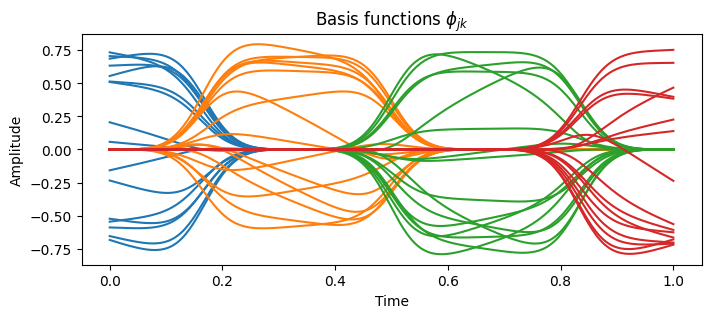

In [8]:
# set random seed
key = jax.random.PRNGKey(0)

# define the neural network architecture and initialise its parameters
network = ELMFBPINN
J = 4
K = 16
parameters_fixed = network.init_parameters(key, [1, K], J)
tranges = network.get_subdomain_tranges(J, 2/(J-1))

# define ODE parameters
d, w0 = 2, 20
mu, k = 2*d, w0**2

# get dense test points and exact solution to compare to
t_test_batch = jnp.linspace(0,1,300).reshape(-1,1)
u_exact_batch = jax.vmap(exact_solution, in_axes=(None,None,0))(d, w0, t_test_batch)


## Task: plot the basis functions for each subdomain
## hint: use `network.forward_basis` to get the basis functions for all subdomain networks
## and `vmap` it over a set of test time points

phis_batch = jax.vmap(network.forward_basis, in_axes=(None,None,0))(parameters_fixed, tranges, t_test_batch)
plt.figure(figsize=(8,3))
for j_ in range(J):
    for k_ in range(K):
        plt.plot(t_test_batch, phis_batch[:,j_,k_], color=colors[j_%len(colors)])
plt.title("Basis functions $\phi_{jk}$")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

##

### Step 2: Assembling the least-squares system matrices

Next we will use the `ELMFBPINN` class to populate the elements of the matrices $\mathbf{N}$, $\mathbf{B}_1$, and $\mathbf{B}_2$. For this, we need to evaluate the boundary/ODE operators on the windowed basis functions, $\omega_j \phi_{jk}$, at boundary/collocation points.

> Task 3: complete the `physics_terms` and `boundary_terms` functions

In [9]:
def physics_terms(parameters_fixed, tranges, t, network, mu, k):
    """Compute a row of the N matrix and f vector for the 1D harmonic oscillator problem.
    Parameters:
        parameters_fixed: network parameters
        tranges: array of shape (J, 2) containing tmin, tmax of each subdomain
        t: SINGLE input point of shape (1,)
        network: network class
        mu: coefficient of friction
        k: spring constant
    Returns:
        matrix_N_row: single row of the N matrix, of shape (J*K,)
        vector_f_element: single element of the f vector, of shape ()
    """

    assert t.shape == (1,)

    def basis_fn(t):
        """Calls network.forward_basis, isolating phis(t) as a vector function of a scalar input
        suitable for jax.jacfwd"""
        return network.forward_basis(parameters_fixed, tranges, t.reshape(1,))# has shape (J,K)
    t = t.squeeze()# has shape ()

    phis = basis_fn(t)# has shape (J,K)

    ## Task: use `jax.jacfwd` to compute the gradients of basis_fn at t, dphisdt and d2phisdt2, which should both have shape (J,K)

    dphisdt_fn = jax.jacfwd(basis_fn)
    dphisdt = dphisdt_fn(t)

    d2phisdt2_fn = jax.jacfwd(dphisdt_fn)
    d2phisdt2 = d2phisdt2_fn(t)

    ##

    assert d2phisdt2.ndim == dphisdt.ndim == phis.ndim == 2

    matrix_N_row = d2phisdt2 + mu*dphisdt + k*phis# has shape (J,K)
    vector_f_element = 0

    return matrix_N_row.flatten(), vector_f_element


def boundary_terms(parameters_fixed, tranges, t, network):
    """Compute a row of the two boundary matrices and vectors for the 1D harmonic oscillator problem.
    Parameters:
        parameters_fixed: network parameters
        tranges: array of shape (J, 2) containing tmin, tmax of each subdomain
        t: SINGLE input point of shape (1,)
        network: network class
        mu: coefficient of friction
        k: spring constant
    Returns:
        matrix_B1_row: single row of the B1 matrix, of shape (J*K,)
        vector_g1_element: single element of the g1 vector, of shape ()
        matrix_B2_row: single row of the B2 matrix, of shape (J*K,)
        vector_g2_element: single element of the g2 vector, of shape ()
    """

    assert t.shape == (1,)

    def basis_fn(t):
        """Calls network.forward_basis, isolating phis(t) as a vector function of a scalar input
        suitable for jax.jacfwd"""
        return network.forward_basis(parameters_fixed, tranges, t.reshape(1,))# has shape (J,K)
    t = t.squeeze()# has shape ()

    ## Task: similar to `physics_terms`, compute phis and dphisdt

    phis = basis_fn(t)# has shape (J,K)
    dphisdt_fn = jax.jacfwd(basis_fn)
    dphisdt = dphisdt_fn(t)

    ##

    assert dphisdt.ndim == phis.ndim == 2

    matrix_B1_row = phis# has shape (J,K)
    vector_g1_element = 1

    matrix_B2_row = dphisdt# has shape (J,K)
    vector_g2_element = 0

    return matrix_B1_row.flatten(), vector_g1_element, matrix_B2_row.flatten(), vector_g2_element

> Task 4: run the code below to assemble the M matrix

In [10]:
def assemble_system(parameters_fixed, tranges, t_physics_batch, t_boundary, network, mu, k):
    """Assembles M and h in the least-squares system, ||Ma - h||^2 = 0.
    Returns:
        M: matrix of shape (N, J*K), where N is the total number of training points
        and J*K is the total number of basis functions
        h: vector of shape (N,)

    Note M and h are constructed by vertically stacking the individual physics loss and boundary
    losses matrices and vectors.
    """

    # compute matrix entries for physics loss
    N, f = jax.vmap(physics_terms, in_axes=(None, None, 0, None, None, None))(
        parameters_fixed, tranges, t_physics_batch, network, mu, k)

    # compute matrix entries for boundary losses
    B1,g1,B2,g2 = jax.vmap(boundary_terms, in_axes=(None, None, 0, None))(
        parameters_fixed, tranges, jnp.array([t_boundary]), network)

    # get combined least squares system, weighting terms appropriately
    M = jnp.concatenate([jnp.sqrt(1e-4/N.shape[0])*N, B1, jnp.sqrt(1e-1)*B2], axis=0)
    h = jnp.concatenate([jnp.sqrt(1e-4/N.shape[0])*f, g1, jnp.sqrt(1e-1)*g2], axis=0)

    return M, h

@partial(jax.jit, static_argnums=(2,3))
def solve_system(M, h, J, K):
    """Solve the least-squares problem ||Ma - h||^2 = 0.
    Returns:
        a: basis function coefficients of shape (J,K)
    """

    assert M.shape[1] == J*K and M.shape[:1] == h.shape
    a, residuals, rank, s = jnp.linalg.lstsq(M, h, rcond=0)
    a = a.reshape(J,K)
    return a


# Train the ELM-FBPINN

# define boundary point, for the boundary loss
t_boundary = jnp.array([0.])# has shape (1,)

# define batch of training points over the entire problem domain [0,1], for the physics loss
t_physics_batch = jnp.linspace(0,1,50).reshape(-1,1)# has shape (50, 1)

# assemble the linear system
M, h = assemble_system(parameters_fixed, tranges, t_physics_batch, t_boundary, network, mu, k)
print(f"Least-squares system assembled: M has shape {M.shape}, h has shape {h.shape}")

Least-squares system assembled: M has shape (52, 64), h has shape (52,)


> Task 5: plot the sparsity pattern of M. Note that most elements of M are zero, why is this?

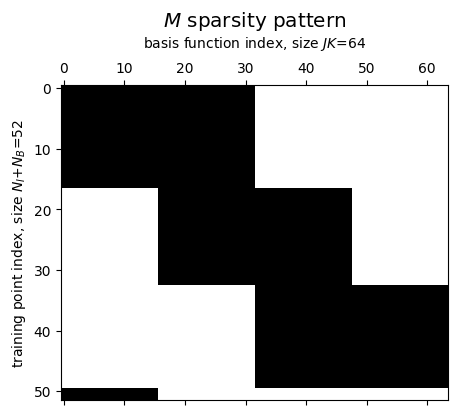

In [11]:
## Task: plot the sparsity pattern of M
## note that most elements of M are zero, why is this?

plt.figure(figsize=(5,5))
plt.spy(M)
plt.title("$M$ sparsity pattern", fontsize="x-large")
plt.xlabel(f"basis function index, size $JK$={M.shape[1]}", labelpad=10)
plt.gca().xaxis.set_label_position("top")
plt.ylabel(f"training point index, size $N_{{I}}$+$N_{{B}}$={M.shape[0]}")
plt.show()

##

### Step 3: Solving the least-squares problem and evaluating performance

Finally, we can solve the least-squares system with `jax.numpy.linalg.lstsq`.

> Task 6: run the code below to solve the least-squares system

Total training time: 0.0018701553344726562 seconds


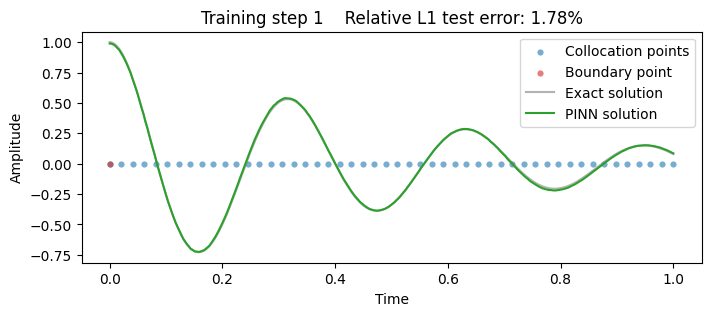

In [12]:
# solve the least-squares problem
a = solve_system(M, h, J, K)

# run it again for accurate timing (as jit requires a warmup call)
start = time.time()
a = solve_system(M, h, J, K)
a = a.block_until_ready()
print(f"Total training time: {time.time()-start} seconds")

# plot solution
i=0
u_test_batch = jax.vmap(network.forward, in_axes=(None,None,None,0))(parameters_fixed, tranges, a, t_test_batch)
plot_result(i, t_physics_batch, t_boundary, t_test_batch, u_exact_batch, u_test_batch)

> Task 7: measure the total training time, and compare this to the JAX FBPINN. Which is faster, and why?

> Optional extension tasks. If you have the time, consider these extensions:
> 1. Try different hyperparmeters (e.g. number of subdomains, number of basis functions); how sensitive is the solver to them?
> 2. Think about how to accelerate the solver even further. One way would be to exploit the sparsity of M; how can this be used to accelerate training further?

In [13]:
## Task: measure the total training time, and compare this to the JAX FBPINN. Which is faster, and why?

## Task (optional extensions): if you have the time, consider these extensions:
    # 1. try different hyperparmeters (e.g. number of subdomains, number of basis functions);
    # how sensitive is the solver to them?
    # 2. think about how to accelerate the solver even further. One way would be to exploit
    # the sparsity of M; how can this be used to accelerate training further?